In [1]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from pyscf.grad import RHF as g

In [2]:
import inspect
import sys
sys.path.append("../Libs")
from FcMole import FcM,FcM_like
from FDcoeffs import get_coeffs

In [3]:
#5pts finite difference coefficients
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]
fds5=get_coeffs(5)
fds7=get_coeffs(7)

The formula for the gradient is stated in Pople's article (Eq.21) as: 
$$ \frac{\partial E}{\partial Z}= \sum_{\mu\nu}P_{\mu\nu}\frac{\partial H_{\mu\nu}}{\partial Z}+\frac{1}{2}\sum_{\mu\nu\lambda\sigma}
P_{\mu\nu}P_{\lambda\sigma}\frac{\partial}{\partial Z}(\mu \lambda | | \nu\sigma)+\frac{\partial V_{nuc}}{\partial Z} 
-\sum_{\mu\nu}W_{\mu\nu}\frac{\partial S_{\mu\nu}}{\partial Z}
$$
$W$ is an energy weighted density matrix:
$$ W_{\mu\nu}= \sum_i ^{mo.occ.} \epsilon_i c_{\mu i} c_{\nu i}^\dagger
$$

In [4]:
nn=gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("pcX-1",fmt="nwchem",elements=[6,7,8]))
mf=scf.RHF(nn)
e_nn=mf.scf()

converged SCF energy = -108.916591616523


In [5]:
S_nn=mf.get_ovlp()
h1_nn=mf.get_hcore()
P=mf.make_rdm1()
g_ijkl=nn.intor('int2e', aosym='s8')

C=mf.mo_coeff
O=mf.mo_occ
e=mf.mo_energy

In [6]:
%load_ext autoreload
%autoreload 2
from ao_scf import ao_RHF

In [7]:
nn2=gto.M(atom="C 0 0 0; O 0 0 2.05",unit="Bohr",basis=bse.get_basis("pcX-1",fmt="nwchem",elements=[6,7,8]))
aor=ao_RHF(nn2,S_ao=S_nn,hcore=h1_nn,eri=g_ijkl)

In [8]:
aor.scf()+1/2.05

converged SCF energy = -109.404396494572


<class 'ao_scf.ao_RHF'> does not have attributes  S_ao hcore


-108.91659161652339

In [9]:
cn=gto.M(atom="C 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("pcX-1",fmt="nwchem",elements=[6,7,8]),charge=-1)
on=gto.M(atom="O 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("pcX-1",fmt="nwchem",elements=[6,7,8]),charge=1)

In [10]:
mf_on=scf.RHF(on)
mf_cn=scf.RHF(cn)
e_on=mf_on.scf()
e_cn=mf_cn.scf()

converged SCF energy = -128.874363294639
converged SCF energy = -92.2576688695164


In [38]:
dS=(mf_on.get_ovlp()-mf_cn.get_ovlp())/2
dh1=(mf_on.get_hcore()-mf_cn.get_hcore())/2
dG=(on.intor('int2e', aosym='s8')-cn.intor('int2e', aosym='s8'))/2
dVnn=(8*7-7*7)/2.05
d2S=(mf_on.get_ovlp()+mf_cn.get_ovlp()-2*mf.get_ovlp())
d2h1=(mf_on.get_hcore()+mf_cn.get_hcore()-2*mf.get_hcore())
d2G=(on.intor('int2e', aosym='s8')+cn.intor('int2e', aosym='s8')-2*nn.intor('int2e', aosym='s8'))

In [16]:
def E(l):
    return ao_RHF(FcM_like(nn,fcs=[l,0]),S_ao=S_nn+dS*l+d2S*l**2/2,hcore=h1_nn+dh1*l+d2h1*l**2/2,\
                  eri=g_ijkl+dG*l+d2G*l**2/2).scf()

In [44]:
(E(.05)-E(-.05))/.1

converged SCF energy = -109.833121453482
converged SCF energy = -108.008341537207


-18.24779916274565

In [28]:
#from np.grad.rhf   , makes w
def make_rdm1e(mo_energy, mo_coeff, mo_occ):
    '''Energy weighted density matrix'''
    mo0 = mo_coeff[:,mo_occ>0]
    mo0e = mo0 * (mo_energy[mo_occ>0] * mo_occ[mo_occ>0])
    return np.dot(mo0e, mo0.T)

In [51]:
W=make_rdm1e(e,C,O)
W

array([[-6.52101832e-04, -4.87216027e-03, -2.22175783e-02, ...,
         7.79296386e-04,  8.55882412e-18,  5.95188150e-20],
       [-4.87216027e-03, -3.64022865e-02, -1.65997922e-01, ...,
         5.82717436e-03,  6.66750832e-17,  4.52624997e-19],
       [-2.22175783e-02, -1.65997922e-01, -7.56979799e-01, ...,
         2.67049499e-02,  2.78442703e-16,  1.93573027e-18],
       ...,
       [ 7.79296386e-04,  5.82717436e-03,  2.67049499e-02, ...,
        -5.31885889e-03,  1.83765840e-16,  3.53188488e-18],
       [ 8.55882412e-18,  6.66750832e-17,  2.78442703e-16, ...,
         1.83765840e-16, -2.69365867e-03, -7.06504358e-17],
       [ 5.95188150e-20,  4.52624997e-19,  1.93573027e-18, ...,
         3.53188488e-18, -7.06504358e-17, -4.06783104e-30]])

$$ \frac{\partial E}{\partial Z}= \sum_{\mu\nu}P_{\mu\nu}\frac{\partial H_{\mu\nu}}{\partial Z}+\frac{1}{2}\sum_{\mu\nu\lambda\sigma}
P_{\mu\nu}P_{\lambda\sigma}\frac{\partial}{\partial Z}(\mu \lambda | | \nu\sigma)+\frac{\partial V_{nuc}}{\partial Z} 
-\sum_{\mu\nu}W_{\mu\nu}\frac{\partial S_{\mu\nu}}{\partial Z}
$$
$W$ is an energy weighted density matrix:
$$ W_{\mu\nu}= \sum_i ^{mo.occ.} \epsilon_i c_{\mu i} c_{\nu i}^\dagger
$$

In [52]:
dG4d=(on.intor('int2e')-cn.intor('int2e'))/2   # move to J-k/2
np.einsum("ij,ij",P,dh1),0.5*np.einsum("ij,kl,ijkl",P,P,dG4d) ,dVnn,-np.einsum("ij,ij",W,dS),\
np.einsum("ij,ij",P,dh1)+0.5*np.einsum("ij,kl,ijkl",P,P,dG4d) +dVnn-np.einsum("ij,ij",W,dS)

(-23.649717805620035,
 2.793744776549527,
 3.414634146341464,
 -0.06667508592368225,
 -17.508013968652726)

In [64]:
# This works  forgot to K-J/2
np.einsum("ij,ij",P,dh1)+0.5*np.einsum("ij,kl,ijkl",P,P,dG4d)-np.einsum("ik,jl,ijkl",P,P,dG4d)/4 +dVnn-np.einsum("ij,ij",W,dS)

-18.24763086165771

In [222]:
e_nn,np.einsum("ij,ij",P,dh1)+0.5*np.einsum("ij,kl,ijkl",P,P,dG4d) +dVnn-np.einsum("ij,ij",W,dS)*8,\
e_nn+np.einsum("ij,ij",P,dh1)+0.5*np.einsum("ij,kl,ijkl",P,P,dG4d) +dVnn-np.einsum("ij,ij",W,dS)

(-108.91659161652339, -17.974739570118693, -126.42460558517618)

In [232]:
e_nn-np.einsum("ij,ij",P,dh1)-0.5*np.einsum("ij,kl,ijkl",P,P,dG4d) -dVnn+np.einsum("ij,ij",W,dS)

-91.4085776478706

In [224]:
e_on,e_cn

(-128.87436329463884, -92.25766886951638)

In [ ]:
########################################################### Finish

In [225]:
def E_cn(l):
    mol_l=FcM(fcs=[l,0],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7+l,ref=7),"N2":pcX(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e
def P_cn(l):
    mol_l=FcM(fcs=[l,0],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7+l,ref=7),"N2":pcX(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    p=mf_l.make_rdm1()
    return p

In [226]:
E_cn(1),E(1)

converged SCF energy = -128.874363294644


(-128.87436329464583, -128.87436329464418)

For the second alchemical derivative we need at first the response matrix

In [197]:
#The old code for nbs derivs
def alchemy_pol_deriv(polobj,dL, with_cphf=True):
    mf = polobj._scf
    mol = mf.mol
    mo_energy = mf.mo_energy
    mo_coeff = mf.mo_coeff
    mo_occ = mf.mo_occ
    occidx = mo_occ > 0
    orbo = mo_coeff[:, occidx]
    orbv = mo_coeff[:,~occidx]

    charges = mol.atom_charges()
    coords  = mol.atom_coords()
    charge_center = np.einsum('i,ix->x', charges, coords) / charges.sum()
    
    int_r=DeltaV(mol,dL)    ########   .001 as finite difference intervall  
    h1 = lib.einsum('xpq,pi,qj->xij', int_r, mo_coeff.conj(), orbo) #going to molecular orbitals?
    s1 = np.zeros_like(h1)
    vind = polobj.gen_vind(mf, mo_coeff, mo_occ)
    if with_cphf:
        mo1,e1 = cphf.solve(vind, mo_energy, mo_occ, h1, s1, polobj.max_cycle_cphf, polobj.conv_tol)
    else:
        mo1 = rhf_nmr._solve_mo1_uncoupled(mo_energy, mo_occ, h1, s1)[0]
    return mo1,e1[0]

In [198]:
#attempt to o this for luck
from pyscf.scf import cphf
vind = mf.Polarizability().gen_vind(mf, C, O)
mo1,e1 = cphf.solve(vind, e, O, -dh1[:,:7], dS[:,:7], 20 ,1e-5)

In [199]:
mo1.shape,e1.shape

((48, 7), (7, 7))

In [246]:
def make_dP(mf,mo1):
    mol=mf.mol
    nao=mol.nao
    nocc=mf.mol.nelec[0]
    C=mf.mo_coeff
    dP=np.zeros_like(C)
    dP[:,:]=2*np.einsum('ij,jk,lk->il',C,mo1,C[:,:nocc])
    return dP+dP.T

def make_U(mo1):
    U=np.zeros((mo1.shape[0],mo1.shape[0]))
    U[:,:mo1.shape[1]]=mo1
    U=U-U.T
    return U

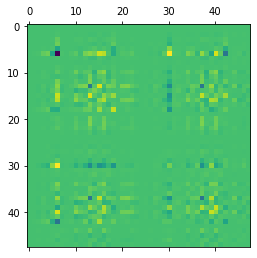

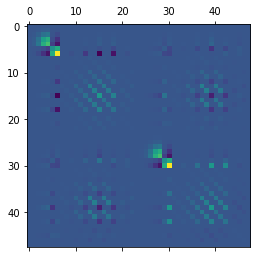

In [247]:
dP=make_dP(mf,mo1)
plt.matshow(dP)
plt.matshow(P)

In [248]:
P+dP*.001

array([[ 4.34475739e-05,  3.24702608e-04,  1.48414963e-03, ...,
        -1.03623503e-04,  6.07770309e-09, -5.32105084e-10],
       [ 3.24702608e-04,  2.42666496e-03,  1.10918411e-02, ...,
        -7.73017248e-04,  1.51608733e-07, -4.21244423e-09],
       [ 1.48414963e-03,  1.10918411e-02,  5.07064903e-02, ...,
        -3.66308416e-03,  7.43845139e-07, -1.89475051e-08],
       ...,
       [-1.03623503e-04, -7.73017248e-04, -3.66308416e-03, ...,
         3.80426340e-03,  3.43315708e-06, -6.70777360e-08],
       [ 6.07770309e-09,  1.51608733e-07,  7.43845139e-07, ...,
         3.43315708e-06,  4.37659595e-03, -1.53341786e-06],
       [-5.32105084e-10, -4.21244423e-09, -1.89475051e-08, ...,
        -6.70777360e-08, -1.53341786e-06, -6.55052511e-20]])

In [249]:
from numpy.linalg import norm
norm(P_cn(-1)-(P+dP))

1.8526613104384053

In [250]:
P@S@P-2*P

array([[-1.08420217e-19, -6.50521303e-19, -3.90312782e-18, ...,
         1.89735380e-19, -2.63657223e-20, -5.89816045e-34],
       [-5.42101086e-19, -5.20417043e-18, -2.77555756e-17, ...,
         6.50521303e-19, -1.97735593e-19, -4.26112000e-33],
       [-2.16840434e-18, -2.77555756e-17, -1.11022302e-16, ...,
         3.46944695e-18, -9.16971604e-19, -1.82963345e-32],
       ...,
       [ 8.13151629e-20,  6.50521303e-19,  5.20417043e-18, ...,
         6.93889390e-18,  1.92597824e-19,  1.23259516e-32],
       [-2.63657223e-20, -1.97735593e-19, -9.16971604e-19, ...,
         1.92597824e-19, -6.93889390e-18, -4.93038066e-32],
       [-5.50695593e-34, -4.38149062e-33, -2.04148574e-32, ...,
         6.16297582e-33, -4.93038066e-32, -1.75162308e-45]])

In [251]:
norm((P+dP)@S@(P+dP)-2*(P+dP))

0.7681821538176071

In [252]:
norm(P_cn(-1)-(P))

1.2481929404653678

In [207]:
# FOR HESSIAN CALCULATIONS 
# if mo1 is None or mo_e1 is None:
#         mo1, mo_e1 = hessobj.solve_mo1(mo_energy, mo_coeff, mo_occ, h1ao,
#                                        None, atmlst, max_memory, log)
"""
def solve_mo1(mf, mo_energy, mo_coeff, mo_occ, h1ao_or_chkfile,
              fx=None, atmlst=None, max_memory=4000, verbose=None):
    '''Solve the first order equation

    Kwargs:
        fx : function(dm_mo) => v1_mo
            A function to generate the induced potential.
            See also the function gen_vind.
    '''
    mol = mf.mol
    if atmlst is None: atmlst = range(mol.natm)

    nao, nmo = mo_coeff.shape
    mocc = mo_coeff[:,mo_occ>0]
    nocc = mocc.shape[1]

    if fx is None:
        fx = gen_vind(mf, mo_coeff, mo_occ)
    s1a = -mol.intor('int1e_ipovlp', comp=3)

    def _ao2mo(mat):
        return numpy.asarray([reduce(numpy.dot, (mo_coeff.T, x, mocc)) for x in mat])

    mem_now = lib.current_memory()[0]
    max_memory = max(2000, max_memory*.9-mem_now)
    blksize = max(2, int(max_memory*1e6/8 / (nmo*nocc*3*6)))
    mo1s = [None] * mol.natm
    e1s = [None] * mol.natm
    aoslices = mol.aoslice_by_atom()
    for ia0, ia1 in lib.prange(0, len(atmlst), blksize):
        s1vo = []
        h1vo = []
        for i0 in range(ia0, ia1):
            ia = atmlst[i0]
            shl0, shl1, p0, p1 = aoslices[ia]
            s1ao = numpy.zeros((3,nao,nao))
            s1ao[:,p0:p1] += s1a[:,p0:p1]
            s1ao[:,:,p0:p1] += s1a[:,p0:p1].transpose(0,2,1)
            s1vo.append(_ao2mo(s1ao))
            if isinstance(h1ao_or_chkfile, str):
                key = 'scf_f1ao/%d' % ia
                h1ao = lib.chkfile.load(h1ao_or_chkfile, key)
            else:
                h1ao = h1ao_or_chkfile[ia]
            h1vo.append(_ao2mo(h1ao))

        h1vo = numpy.vstack(h1vo)
        s1vo = numpy.vstack(s1vo)
        mo1, e1 = cphf.solve(fx, mo_energy, mo_occ, h1vo, s1vo)
        mo1 = numpy.einsum('pq,xqi->xpi', mo_coeff, mo1).reshape(-1,3,nao,nocc)
        e1 = e1.reshape(-1,3,nocc,nocc)

        for k in range(ia1-ia0):
            ia = atmlst[k+ia0]
            if isinstance(h1ao_or_chkfile, str):
                key = 'scf_mo1/%d' % ia
                lib.chkfile.save(h1ao_or_chkfile, key, mo1[k])
            else:
                mo1s[ia] = mo1[k]
            e1s[ia] = e1[k].reshape(3,nocc,nocc)
        mo1 = e1 = None

    if isinstance(h1ao_or_chkfile, str):
        return h1ao_or_chkfile, e1s
    else:
        return mo1s, e1s

"""

"\ndef solve_mo1(mf, mo_energy, mo_coeff, mo_occ, h1ao_or_chkfile,\n              fx=None, atmlst=None, max_memory=4000, verbose=None):\n    '''Solve the first order equation\n\n    Kwargs:\n        fx : function(dm_mo) => v1_mo\n            A function to generate the induced potential.\n            See also the function gen_vind.\n    '''\n    mol = mf.mol\n    if atmlst is None: atmlst = range(mol.natm)\n\n    nao, nmo = mo_coeff.shape\n    mocc = mo_coeff[:,mo_occ>0]\n    nocc = mocc.shape[1]\n\n    if fx is None:\n        fx = gen_vind(mf, mo_coeff, mo_occ)\n    s1a = -mol.intor('int1e_ipovlp', comp=3)\n\n    def _ao2mo(mat):\n        return numpy.asarray([reduce(numpy.dot, (mo_coeff.T, x, mocc)) for x in mat])\n\n    mem_now = lib.current_memory()[0]\n    max_memory = max(2000, max_memory*.9-mem_now)\n    blksize = max(2, int(max_memory*1e6/8 / (nmo*nocc*3*6)))\n    mo1s = [None] * mol.natm\n    e1s = [None] * mol.natm\n    aoslices = mol.aoslice_by_atom()\n    for ia0, ia1 in lib